In [1]:
!pip install yfinance
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
## Extração de preços

tickers = ['BBDC4.SA', 'TAEE11.SA','PETR4.SA'] # tentar novamente caso algum ticker dê errado

precos = yf.download(tickers, start = '2018-07-26')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  3 of 3 completed


In [2]:
df1=precos['Adj Close']

In [4]:
df1.head()

Ticker,BBDC4.SA,PETR4.SA,TAEE11.SA
Date,,,
2018-07-26,14.583029,7.089534,11.695205
2018-07-27,14.745270,7.221026,11.695205
2018-07-30,14.855027,7.264854,11.689388
2018-07-31,14.568714,7.202763,11.753359
2018-08-01,14.759586,7.308685,11.764990


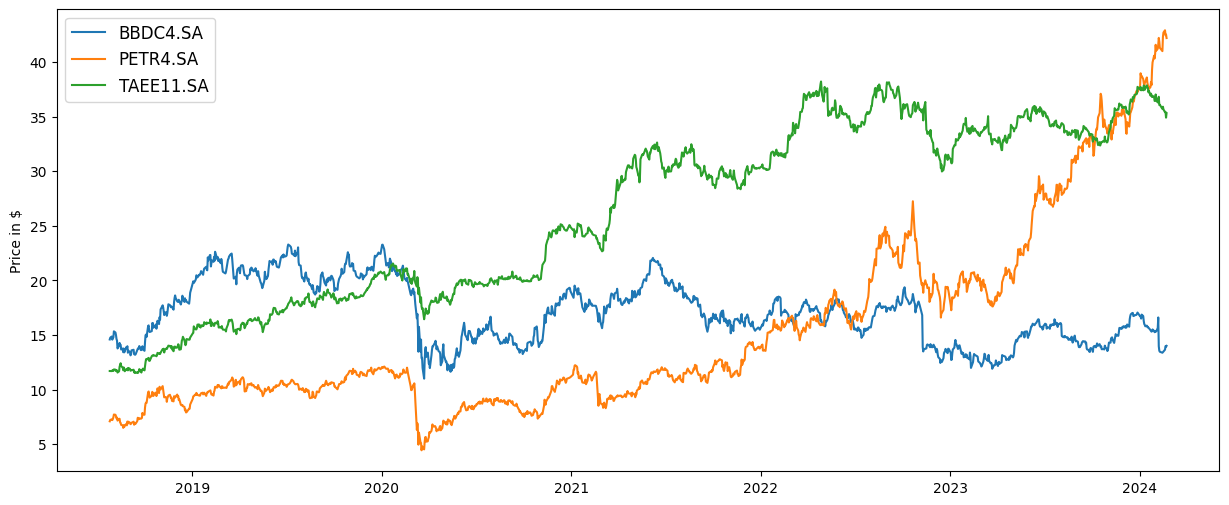

In [5]:
plt.figure(figsize=(15, 6))
for i in range(df1.shape[1]):
    plt.plot(df1.iloc[:,i], label=df1.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

In [10]:
#Calculate daily changes in the stocks' value
df2 = df1.resample('Y').last().pct_change()
#Remove nan values at the first row of df2. Create a new dataframe df
df=df2.iloc[1:len(df2.index),:]
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
r = np.mean(df,axis=0)

# Create a covariance matrix
covar = df.cov()

In [11]:
df2

Ticker,BBDC4.SA,PETR4.SA,TAEE11.SA
Date,,,
2018-12-31,NaN,NaN,NaN
2019-12-31,0.188693,0.374888,0.409575
2020-12-31,-0.152156,-0.060898,0.196248
2021-12-31,-0.185827,0.235102,0.217783
2022-12-31,-0.112951,0.376381,0.033668
2023-12-31,0.241739,0.967218,0.204010
2024-12-31,-0.178861,0.132922,-0.063842


In [12]:
r

Ticker
BBDC4.SA    -0.033227
PETR4.SA     0.337602
TAEE11.SA    0.166240
dtype: float64

In [ ]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [ ]:
# All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((df2.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(df2.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))


[0.   0.11 0.89]
return:  6324.14 risk:  0.106


In [ ]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.   0.12 0.88]
return:  6333.39 risk:  0.106


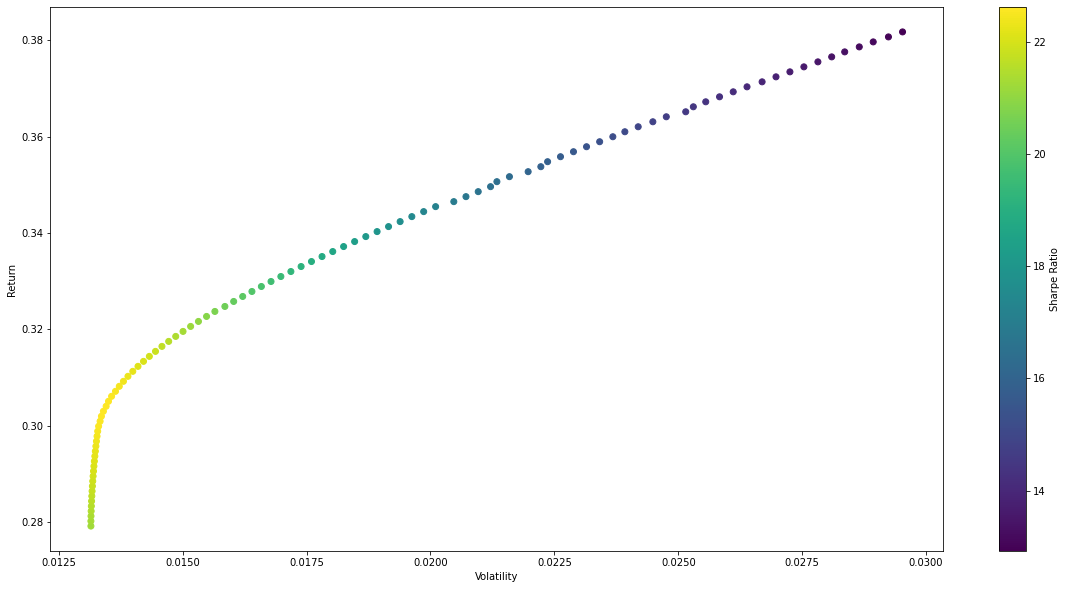

In [ ]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports


all_weights = np.zeros((num_ports, len(df.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(df2.shape[1]),r],[1,port_ret],[1,port_ret])

    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)

    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)

sharpe_arr = ret_arr/vol_arr

plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()